[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/juansensio/blog/blob/master/113_sd_scratch_2/113_sd_scratch_2.ipynb)

# Stable Diffusion desde cero - Parte 2

En el post anterior vimos una introducción a los modelos de difusión, implementando Stable Diffusion desde cero para generación de imágenes. Sin embargo las imágenes generadas por el modelo eran aleatorias, si bien se parecen a imágenes del dataset MNIST (el cual usamos para entrenar el modelo). En este post vamos a mejorar nuestra implementación añadiendo la capacidad de controlar la imagen generada, de la misma forma que con Stable Diffusion podemos describir el contenido de la imagen mediante texto.

![](https://images.squarespace-cdn.com/content/v1/628be1d26f9ad648b2e202b1/43a38f92-eb67-4218-8789-55250e4b8827/txt2img.png)

Seguimos usando el mismo dataset.

In [16]:
from sklearn.datasets import fetch_openml
import numpy as np


# mnist = fetch_openml('mnist_784', version=1)
# # importante que las imágenes estén en el rango -1, 1
# X, Y = 2. * (mnist["data"].values.astype(float).reshape(-1, 28, 28) / 255.) - 1., mnist["target"].values.astype(int)
# np.savez_compressed("mnist.npz", X=X, Y=Y)

# la descarga puede tardar un rato, así que te recomiendo comentar las líneas anteriores después 
# de ejecutarlas la primera vez y descomentar las siguientes para cargar los datos desde el disco

X, Y = np.load("mnist.npz")["X"], np.load("mnist.npz")["Y"]

X.shape, Y.shape

((70000, 28, 28), (70000,))

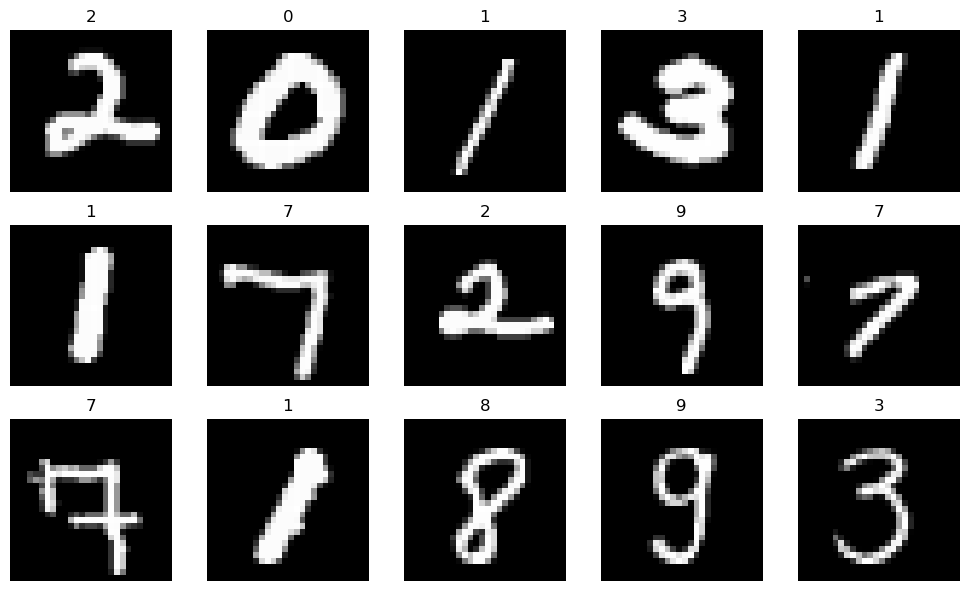

In [17]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import random 

r, c = 3, 5
fig = plt.figure(figsize=(2*c, 2*r))
for _r in range(r):
    for _c in range(c):
        plt.subplot(r, c, _r*c + _c + 1)
        ix = random.randint(0, len(X)-1)
        plt.imshow(X[ix], cmap='gray')
        plt.axis("off")
        plt.title(Y[ix])
plt.tight_layout()
plt.show()

## Añadiendo información sobre la imagen a generar

Lo más sencillo que podemos hacer si queremos controlar el comportamiento de nuestro modelo para generar la imagen que queramos es añadir la etiqueta de la que disponemos. Para ello usaremos la misma aproximación que vimos en el post anterior para añadir al modelo información sobre el `step` del `noise scheduler`. En nuestro caso, introduciremos la etiqueta en formato `one-hot encoding`, la proyectaremos a la misma dimensión que el embedding del `step` y los sumaremos.

In [18]:
from unet import UNet, SinusoidalPositionEmbeddings
import math
import torch

class ConditionalDiffusionModel(torch.nn.Module):
	def __init__(self, embed_dim=32):
		super().__init__()
		self.time_embed = SinusoidalPositionEmbeddings(embed_dim)
		self.label_embed = torch.nn.Linear(10, embed_dim)
		self.unet = UNet(in_ch=1 + embed_dim, n_classes=1)

	def forward(self, x, t, y):
		B, C, H, W = x.shape
		t = self.time_embed(t)
		t = t[:, :, None, None].repeat(1, 1, H, W)
		y = torch.nn.functional.one_hot(y, 10).float()
		y = self.label_embed(y)
		y = y[:, :, None, None].repeat(1, 1, H, W)
		t = t + y
		x = torch.cat((x, t), dim=1)
		return self.unet(x)

model = ConditionalDiffusionModel()
output = model(torch.randn(10, 1, 28, 28), torch.randint(0, 1000, (10,)), torch.randint(0, 10, (10,)))
output.shape

torch.Size([10, 1, 28, 28])

A este modelo se le llama `Conditional` ya que está *condicionado* por la información extra que le pasamos (en este caso la etiqueta de la imagen).

## Entrenamiento del modelo

Pues con este simple cambio ya tenemos nuestro modelo listo para entrenar. Primero, vamos a actualizar nuestro Dataset.

In [19]:
import numpy as np 

def noise_scheduler(start=1e-4, end=0.02, steps=1000):
	betas = torch.linspace(start, end, steps)
	alphas = 1. - betas
	alphas_hat = torch.cumprod(alphas, axis=0)
	return betas, alphas, alphas_hat

class Dataset(torch.utils.data.Dataset):
	def __init__(self, X, y, T=1000):
		self.X = X
		self.y = y
		self.T = T
		self.betas, self.alphas, self.alphas_hat = noise_scheduler(steps=T)

	def __len__(self):
		return len(self.X)

	def __getitem__(self, ix):
		im = torch.from_numpy(self.X[ix]) # imagen original
		t = torch.randint(0, self.T, (1,))
		noise = torch.randn_like(im) # ruido
		x = noise * torch.sqrt(1 - self.alphas_hat[t]) + im * torch.sqrt(self.alphas_hat[t]) # imagen con ruido
		return x.unsqueeze(0).float(), noise.unsqueeze(0).float(), t, self.y[ix]

Y ya podemos entrenar el modelo

In [20]:
import tqdm

EPOCHS = 10
BATCH_SIZE = 32

ds = Dataset(X, Y) 
dl = torch.utils.data.DataLoader(ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
model = ConditionalDiffusionModel().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

model.train()
for epoch in range(1, EPOCHS+1):
	losses = []
	pb = tqdm.tqdm(dl)
	for im, noise, t, y in pb:
		im, noise, t, y = im.cuda(), noise.cuda(), t.cuda().squeeze(-1), y.cuda()
		output = model(im, t, y)
		loss = torch.nn.functional.mse_loss(output, noise)
		loss.backward()
		optimizer.step()
		optimizer.zero_grad()
		losses.append(loss.item())
		pb.set_description(f'Epoch {epoch}/{EPOCHS} loss {np.mean(losses):.5f}')

Epoch 10/10 loss 0.02796: 100%|██████████| 2188/2188 [00:25<00:00, 86.51it/s]


Y podemos generar nuevas imágenes de la siguiente manera, ¡ahora controlando el dígito a generar!

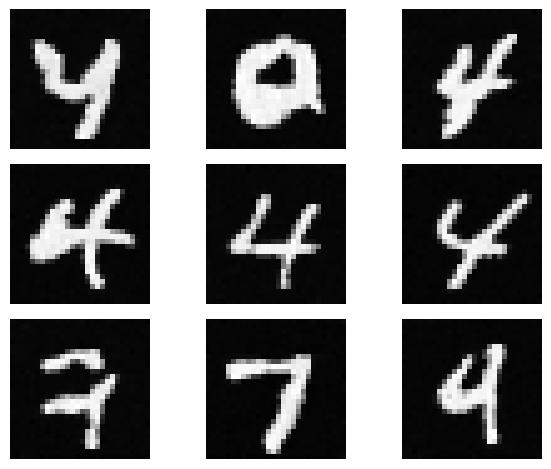

In [24]:
model.eval()

x = torch.randn(1, 1, 28, 28).cuda() # ruido inicial
y = 9 # la etiqueta

r, c = 3, 3
fig = plt.figure(dpi=100)
for i in range(r*c):
	for t in reversed(range(ds.T)):
		with torch.no_grad():
			output = model(x, torch.tensor([t]).cuda(), torch.tensor([y]).long().cuda())
		if t > 0:
			noise = torch.randn_like(x)
		else:
			noise = torch.zeros_like(x)
		x = 1. / torch.sqrt(ds.alphas[t]) * (x - ((1. - ds.alphas[t])/(torch.sqrt(1. - ds.alphas_hat[t]))) * output) + noise * torch.sqrt(ds.betas[t])
	ax = plt.subplot(r, c, i + 1)
	ax.imshow(x[0][0].cpu().numpy(), cmap='gray')
	ax.axis("off")
plt.tight_layout()
plt.show()

Si bien hemos podido entrenar nuestro modelo los resultados que nos proporciona no son del todo convincentes ni estables. Para ello vamos a necesitar introducir un par de mejoras en nuestro modelo, proceso de entrenamiento y de sampleado.

## Mejorando el modelo

Nuestra UNet sencilla nos ha permitido generar imágenes de dígitos de manera convincente, pero para poder obtener mejores resultados ahora que estamos añadiendo información adicional vamos a necesitar una arquitectura que permita aprovechar esta información en todas las capas del encoder y el decoder (no sólo a la entrada como estamos haciendo ahora).

![model](model.png)

*Imagen extraída de https://www.youtube.com/watch?v=TBCRlnwJtZU.

In [25]:
import torch.nn.functional as F

def conv3x3_bn(ci, co):
    return torch.nn.Sequential(
        torch.nn.Conv2d(ci, co, 3, padding=1),
        torch.nn.BatchNorm2d(co),
        torch.nn.ReLU(inplace=True)
    )


class EncoderConv(torch.nn.Module):
    def __init__(self, ci, co, embed_dim):
        super().__init__()
        self.conv = torch.nn.Sequential(
            torch.nn.MaxPool2d(2),
            conv3x3_bn(ci, co),
            conv3x3_bn(co, co),
        )
        self.embed = torch.nn.Linear(embed_dim, co)

    def forward(self, x, t):
        x = self.conv(x)
        B, C, H, W = x.shape
        e = self.embed(t)[:, :, None, None].repeat(1, 1, H, W)
        return x + e

class DecoderConv(torch.nn.Module):
    def __init__(self, ci, co, embed_dim):
        super().__init__()
        self.upsample = torch.nn.ConvTranspose2d(ci, co, 2, stride=2)
        self.conv1 = conv3x3_bn(ci, co)
        self.conv2 = conv3x3_bn(co, co)
        self.embed = torch.nn.Linear(embed_dim, co)


    def forward(self, x1, x2, t):
        x1 = self.upsample(x1)
        diffX = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, (diffX, 0, diffY, 0))
        x = torch.cat([x2, x1], dim=1)
        x = self.conv1(x)
        x = self.conv2(x)
        B, C, H, W = x.shape
        e = self.embed(t)[:, :, None, None].repeat(1, 1, H, W)
        return x + e


class UNet2(torch.nn.Module):
    def __init__(self, n_classes=1, in_ch=1, embed_dim=32):
        super().__init__()
        # lista de capas en encoder-decoder con número de filtros
        c = [16, 32, 64, 128]
        # primera capa conv que recibe la imagen
        self.conv1 = torch.nn.Sequential(
            conv3x3_bn(in_ch, c[0]),
            conv3x3_bn(c[0], c[0]),
        )
        # capas del encoder
        self.conv2 = EncoderConv(c[0], c[1], embed_dim)
        self.conv3 = EncoderConv(c[1], c[2], embed_dim)
        self.conv4 = EncoderConv(c[2], c[3], embed_dim)
        # capas del decoder
        self.deconv1 = DecoderConv(c[3], c[2], embed_dim)
        self.deconv2 = DecoderConv(c[2], c[1], embed_dim)
        self.deconv3 = DecoderConv(c[1], c[0], embed_dim)
        # útlima capa conv que nos da la máscara
        self.out = torch.nn.Conv2d(c[0], n_classes, 3, padding=1)

    def forward(self, x, t):
        # encoder
        x1 = self.conv1(x)
        x2 = self.conv2(x1, t)
        x3 = self.conv3(x2, t)
        x = self.conv4(x3, t)
        # decoder
        x = self.deconv1(x, x3, t)
        x = self.deconv2(x, x2, t)
        x = self.deconv3(x, x1, t)
        x = self.out(x)
        return x

class ConditionalDiffusionModel2(torch.nn.Module):
    def __init__(self, embed_dim=32):
        super().__init__()
        self.time_embed = SinusoidalPositionEmbeddings(embed_dim)
        self.label_embed = torch.nn.Linear(10, embed_dim)
        self.unet = UNet2(in_ch=1, n_classes=1, embed_dim=embed_dim)

    def forward(self, x, t, y=None):
        B, C, H, W = x.shape
        t = self.time_embed(t)
        if y is not None:
            y = torch.nn.functional.one_hot(y, 10).float()
            y = self.label_embed(y)
            t = t + y
        return self.unet(x, t)

In [26]:
model = ConditionalDiffusionModel2()
output = model(torch.randn(10, 1, 28, 28), torch.randint(0, 1000, (10,)), torch.randint(0, 10, (10,)))
output.shape

torch.Size([10, 1, 28, 28])

## Mejorando el entrenamiento

Para mejorar el entrenamiento usaremos una técnica conocida como `Classifier Free Guidance`. Esta técnica consiste en entrenar el modelo de manera condicional un 90% de las veces e incondicional el 10% restante. De esta manera el modelo aprende a generar imágenes de manera autónoma, pero también aprende a generar imágenes que se parezcan a la etiqueta proporcionada.

In [27]:
import tqdm 

EPOCHS = 10
BATCH_SIZE = 32

ds = Dataset(X, Y) 
dl = torch.utils.data.DataLoader(ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
model = ConditionalDiffusionModel2().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

model.train()
for epoch in range(1, EPOCHS+1):
	losses = []
	pb = tqdm.tqdm(dl)
	for im, noise, t, y in pb:
		im, noise, t, y = im.cuda(), noise.cuda(), t.cuda().squeeze(-1), y.cuda()
		if np.random.rand() < 0.1:
			y = None
		output = model(im, t, y)
		loss = torch.nn.functional.mse_loss(output, noise)
		loss.backward()
		optimizer.step()
		optimizer.zero_grad()
		losses.append(loss.item())
		pb.set_description(f'Epoch {epoch}/{EPOCHS} loss {np.mean(losses):.5f}')

Epoch 10/10 loss 0.02698: 100%|██████████| 2188/2188 [00:30<00:00, 72.61it/s]


## Mejorando el sampleado

La última mejora que podemos hacer es la manera en la que sampleamos imágenes. Para ello interpolaremos linealmente entre la predicción condicional y la incondicional.

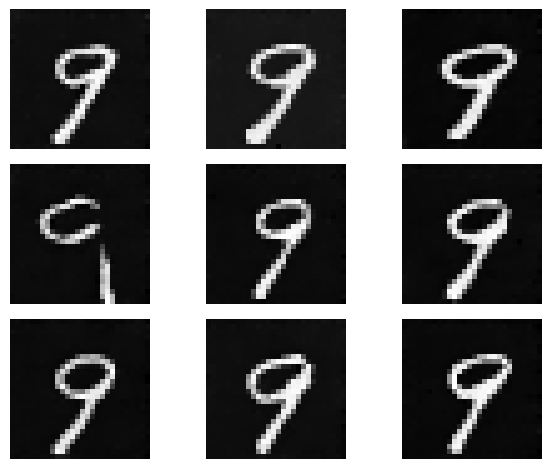

In [31]:
model.eval()

x = torch.randn(1, 1, 28, 28).cuda() # ruido inicial
y = 9 # la etiqueta
cfg = 7.5 # escala del guiado

r, c = 3, 3
fig = plt.figure(dpi=100)
for i in range(r*c):
	for t in reversed(range(ds.T)):
		with torch.no_grad():
			output = model(x, torch.tensor([t]).cuda(), torch.tensor([y]).long().cuda())
			output_uncond = model(x, torch.tensor([t]).cuda(), None)
			output  = torch.lerp(output_uncond, output, cfg)
		if t > 0:
			noise = torch.randn_like(x)
		else:
			noise = torch.zeros_like(x)
		x = 1. / torch.sqrt(ds.alphas[t]) * (x - ((1. - ds.alphas[t])/(torch.sqrt(1. - ds.alphas_hat[t]))) * output) + noise * torch.sqrt(ds.betas[t])
	ax = plt.subplot(r, c, i + 1)
	ax.imshow(x[0][0].cpu().numpy(), cmap='gray')
	ax.axis("off")
plt.tight_layout()
plt.show()

Como podrás observar obtenemos resultados más robustos (ahora si que el modelo siempre nos da una imagen del dígito seleccionado) y también más realistas. Existen otras mejoras que se han publicado recientemente y que te animo a probar en tus experimentos. Algunos ejemplos son el uso de `Exponential Moving Average` (EMA) durante el entrenamiento, usar formulaciones alternativas de UNet con capas residuales o de atención, y muchas otras ya que este campo de la IA está en plena ebullición.

## Resumen

En este post hemos visto como podemos mejorar nuestro modelo de difusión para generar imágenes de dígitos manuscritos convinventes. Para ello hemos introducido en nuestra UNet un vector `one-hot` incluyendo la etiqueta de la imagen provista en el dataset. Además, hemos visto como añadir esta información en todas las etapas del encoder y el decoder para mejores resultados. Otras mejoras que hemos introducido son las presentadas en el paper [`Classifier Free Guidance`](https://arxiv.org/abs/2207.12598), que consisten en entrenar el modelo de manera condicional un 90% de las veces e incondicional el 10% restante, y la interpolación lineal entre la predicción condicional e incondicional a la hora de generar imágenes.

En los siguientes posts aprenderemos a generar imágenes a partir de texto (si has estado atento a mis posts anteriores sobre NLP podrás imaginar que en vez de vectores `one-hot` describiendo la etiqueta usaremos vectores densos de embedding pre-entrenados de alguna manera) luego extendermos nuestra implementación para tratar con imágenes de alta resolución, además de seguir introduciendo mejoras interesantes por el camino.